In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [14]:
categorical_features = ['key', 'mode', 'time_signature']
num_features = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms']
def encode_categorical(df):
    df[categorical_features] = df[categorical_features].astype('category')
    return pd.get_dummies(df, columns=categorical_features, drop_first=True)

data_encoded = encode_categorical(data)

In [16]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   loudness            17996 non-null  float64
 6   speechiness         17996 non-null  float64
 7   acousticness        17996 non-null  float64
 8   instrumentalness    13619 non-null  float64
 9   liveness            17996 non-null  float64
 10  valence             17996 non-null  float64
 11  tempo               17996 non-null  float64
 12  duration_in min/ms  17996 non-null  float64
 13  Class               17996 non-null  int64  
 14  key_2.0             17996 non-null  bool   
 15  key_3.0             17996 non-null  bool   
 16  key_

In [15]:
data_encoded.describe()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,Class
count,17568.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000
mean,44.512124,0.543433,0.662777,-7.910660,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,6.695821
std,17.426928,0.166268,0.235373,4.049151,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,3.206073
min,1.000000,0.059600,0.000020,-39.952000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,0.000000
25%,33.000000,0.432000,0.509000,-9.538000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,5.000000
50%,44.000000,0.545000,0.700000,-7.016000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,8.000000
75%,56.000000,0.659000,0.860000,-5.189000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,10.000000
max,100.000000,0.989000,1.000000,1.355000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,10.000000


In [20]:
data_encoded.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
loudness                 0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
Class                    0
key_2.0                  0
key_3.0                  0
key_4.0                  0
key_5.0                  0
key_6.0                  0
key_7.0                  0
key_8.0                  0
key_9.0                  0
key_10.0                 0
key_11.0                 0
mode_1                   0
time_signature_3         0
time_signature_4         0
time_signature_5         0
dtype: int64

Много пропущенных по популярности и инструменталу

In [24]:
data_encoded.Class.value_counts()
# выборка несбалансирована

Class
10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='Count'>

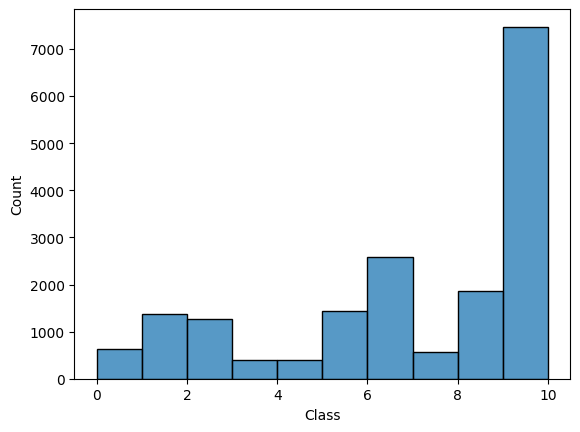

In [25]:
sns.histplot(data_encoded['Class'], bins=10)

In [28]:
pairplot_feat = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'Class']
sns.pairplot(data_encoded[pairplot_feat], hue='Class')

In [ ]:
corr_matrix = data_encoded[pairplot_feat].corr()
fig, ax = plt.subplots(figsize=(16,12))

sns.heatmap(corr_matrix, annot=True,ax=ax)

In [9]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.